<a href="https://colab.research.google.com/github/mepix/CropWeedClassification/blob/main/CropCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Libaries
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
import time
import os
import copy
from torch.utils.data.sampler import WeightedRandomSampler

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Path to the Dataset
#path_to_data = '/content/gdrive/MyDrive/EE244/data/Split-Classes'
path_to_data_train = "/content/gdrive/MyDrive/EE244/data/Data-Train"
path_to_data_test = "/content/gdrive/MyDrive/EE244/data/Data-Test"

# Normalize to Zero Mean
transform = transforms.Compose(
    [
     transforms.Resize([224,224]),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) #MEAN & STDDEV for ResNet
    ])

# Set the Batch Size & Hyperparameters
batch_size = 32
epochs = 100
eta = 0.001
imgDim = 224

# Check GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the Images from the Image Folder
# dataset = datasets.ImageFolder(root=path_to_data, transform=transform)

# Compute samples weight (each sample should get its own weight)
def getSampleWeights(dataset):
  target = torch.Tensor(dataset.targets).type(torch.LongTensor)
  print("Target Labels:",target)
  class_sample_count = torch.tensor(
      [(target == t).sum() for t in torch.unique(target, sorted=True)])
  print("Sample Count:",class_sample_count)
  weight = 1. / class_sample_count.float()
  print("Weights:",weight)
  samples_weight = torch.tensor([weight[t] for t in target])
  print("Samples Weights:",samples_weight)
  sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
  return sampler

# Split into Train and Test Set
# pct_test = 0.25
# train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=pct_test)
# data = {}
# data['train'] = Subset(dataset,train_idx)
# data['test'] = Subset(dataset,test_idx)

# Get Train & Test Set (With Weighted Random Sampling)
data = {}
data['train'] = datasets.ImageFolder(root=path_to_data_train, transform=transform)
data['test'] = datasets.ImageFolder(root=path_to_data_test, transform=transform)

sampler = {}
sampler['train'] = getSampleWeights(data['train'])
sampler['test'] = None


# Build the Train and Test DataLoaders
dataloaders = {x:DataLoader(data[x],batch_size, num_workers=2,sampler=sampler[x]) for x in ['train','test']}
x,y = next(iter(dataloaders['train']))

# Rebundle Datasets
dataset_sizes = {
    'train':len(data['train']),
    'test':len(data['test'])}

# Check Sizes
print(x.shape, y.shape)
# print("Original Dataset",len(dataset))
print("Training Dataset",len(data['train']))
print("Testing Dataset",len(data['test']))
# for i, (x, y) in enumerate(dataloaders['train']):
#     print("batch index {}, 0/1: {}/{}".format(
#         i, (y == 0).sum(), (y == 1).sum()))



Target Labels: tensor([0, 0, 0,  ..., 9, 9, 9])
Sample Count: tensor([ 799, 1591,    8,  301,   28,  113,   61,   14,   46,    5])
Weights: tensor([0.0013, 0.0006, 0.1250, 0.0033, 0.0357, 0.0088, 0.0164, 0.0714, 0.0217,
        0.2000])
Samples Weights: tensor([0.0013, 0.0013, 0.0013,  ..., 0.2000, 0.2000, 0.2000])
torch.Size([32, 3, 224, 224]) torch.Size([32])
Training Dataset 2966
Testing Dataset 1032


In [ ]:
# Compute samples weight (each sample should get its own weight)
# target = torch.Tensor(dataset.targets).type(torch.LongTensor)
# print("Target Labels:",target)
# class_sample_count = torch.tensor(
#     [(target == t).sum() for t in torch.unique(target, sorted=True)])
# print("Sample Count:",class_sample_count)
# weight = 1. / class_sample_count.float()
# print("Weights:",weight)
# samples_weight = torch.tensor([weight[t] for t in target])
# print("Samples Weights:",samples_weight)

# # Create sampler, dataset, loader
# sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
# print("Sampler",sampler)
# train_dataset = torch.utils.data.TensorDataset(data, target)
# train_loader = DataLoader(
#     train_dataset, batch_size=bs, num_workers=1, sampler=sampler)

# Iterate DataLoader and check class balance for each batch
# for i, (x, y) in enumerate(train_loader):
#     print("batch index {}, 0/1: {}/{}".format(
#         i, (y == 0).sum(), (y == 1).sum()))

In [ ]:
# Determine the MEAN and STD Manually and then re-run block
# mean = 0.0
# std = 0.0
# nb_samples = 0.0
# for data in dataloaders['train']: #assume same for test and train data 
#     batch_samples = data.size(0)
#     data = data.view(batch_samples, data.size(1), -1)
#     mean += data.mean(2).sum(0)
#     std += data.std(2).sum(0)
#     nb_samples += batch_samples

# mean /= nb_samples
# std /= nb_samples

# print(mean)
# print(std)
#print(dataset.data.shape)
# print(data['train'].mean(axis=(0,1,2))/255)
# print(trainset.data.std(axis=(0,1,2))/255)
#[0.49139968 0.48215841 0.44653091]
#[0.24703223 0.24348513 0.26158784]

# https://discuss.pytorch.org/t/computing-the-mean-and-std-of-dataset/34949/15
# https://pytorch.org/docs/stable/generated/torch.nn.functional.normalize.html
# https://discuss.pytorch.org/t/about-normalization-using-pre-trained-vgg16-networks/23560/6?u=ptrblck

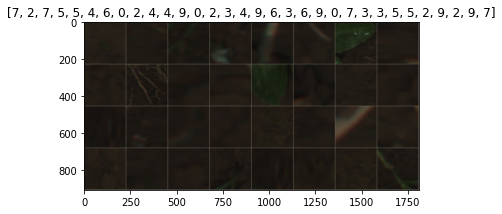

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # Add back the mean and std for visualization
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# INPUTS: a vector of images [batch_size,num_channels,height,width]
# CLASSES: an array containing the index of the appropriate class_names

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Visualize a sample set of images to verify we imported everything OK
imshow(out, title=[int(classes[x]) for x in range(batch_size)])

In [ ]:
def getNetworkModel(model_type="ResNet",step_size=7,gamma=0.1):
  """Create the parameters necessary for the RESNET model"""
  # Load in the ResNet Model
  if model_type == "ResNet":
    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
  else:
    return None #TODO: Try other Models

  # Determine the Number of Features
  # num_ftrs = modelResNet.fc.in_features

  # Size of each output sample is generalized to nn.Linear(num_ftrs, len(class_names))
  # model.fc = nn.Linear(imgDim*imgDim, len(class_names))

  # Push to GPU
  model = model.to(device)

  # Set the Loss Criterion
  criterion = nn.CrossEntropyLoss()

  # Observe that all parameters are being optimized
  optimizer = torch.optim.Adam(model.parameters(), lr=eta) #https://pytorch.org/docs/master/generated/torch.optim.Adam.html

  # Decay LR by a factor of 0.1 every 7 epochs TOO AGGRESSIVE FOR RESNET: 0.01  epoch80 0.001 epoch120 0.0001 (Mayve start at 60 or 40 for smaller data set)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

  return model, criterion, optimizer, scheduler

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Store training values in lists
    training_acc = []
    training_loss = []
    validation_acc = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels.long())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Store Performance in Arrays
            if phase == 'train':
              training_loss.append(epoch_loss)
              training_acc.append(epoch_acc.item())
            else: # must be validation
              validation_acc.append(epoch_acc.item())


            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, training_acc, training_loss, validation_acc



In [ ]:
def plotResults(training_loss,training_acc,test_acc,titleStr=""):
  """Plots the training_loss, training_acc, and test_acc with the provided title"""
  # Create Figure
  plt.figure(figsize=(15,3))
  plt.suptitle(titleStr, fontsize=15)

  # Training Loss Plot
  plt.subplot(131)
  plt.plot(training_loss)
  plt.xlabel('Epoch', fontsize=10)
  plt.ylabel('Training Loss', fontsize=10)
  plt.grid(True)

  # Training Accuracy Plot
  plt.subplot(132)
  plt.plot(training_acc)
  plt.xlabel('Epoch', fontsize=10)
  plt.ylabel('Training Accuracy', fontsize=10)
  plt.grid(True)

  # Test Accuracy Plot
  plt.subplot(133)
  plt.plot(test_acc)
  plt.xlabel('Epoch', fontsize=10)
  plt.ylabel('Test Accuracy', fontsize=10)
  plt.grid(True)

  # Adjust Dimensions
  plt.subplots_adjust(wspace=.5)

Epoch 0/99
----------


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


train Loss: 2.3322 Acc: 0.2003
test Loss: 2.2250 Acc: 0.1008

Epoch 1/99
----------
train Loss: 1.8527 Acc: 0.3338
test Loss: 1.9565 Acc: 0.2452

Epoch 2/99
----------
train Loss: 1.5257 Acc: 0.4471
test Loss: 1.7862 Acc: 0.2200

Epoch 3/99
----------
train Loss: 1.2064 Acc: 0.5550
test Loss: 3.0204 Acc: 0.1638

Epoch 4/99
----------
train Loss: 0.9549 Acc: 0.6531
test Loss: 1.9915 Acc: 0.2771

Epoch 5/99
----------
train Loss: 0.8422 Acc: 0.6902
test Loss: 2.3340 Acc: 0.0543

Epoch 6/99
----------
train Loss: 0.5932 Acc: 0.7653
test Loss: 2.0849 Acc: 0.2277

Epoch 7/99
----------
train Loss: 0.5821 Acc: 0.7680
test Loss: 2.3063 Acc: 0.1996

Epoch 8/99
----------
train Loss: 0.4861 Acc: 0.7994
test Loss: 3.1039 Acc: 0.1977

Epoch 9/99
----------
train Loss: 0.4602 Acc: 0.8227
test Loss: 1.7526 Acc: 0.4273

Epoch 10/99
----------
train Loss: 0.4063 Acc: 0.8412
test Loss: 1.9213 Acc: 0.4341

Epoch 11/99
----------
train Loss: 0.3464 Acc: 0.8628
test Loss: 2.4155 Acc: 0.2810

Epoch 12/99


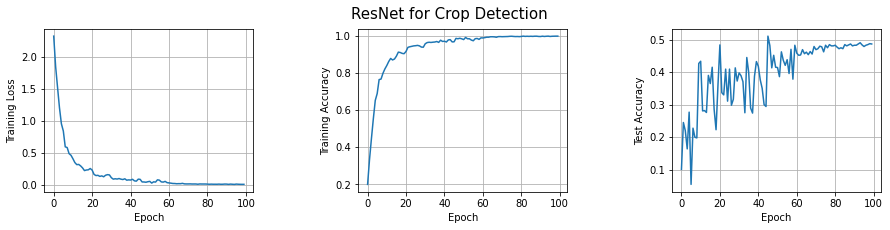

In [ ]:
# Get a Clean Model for No Augmentation
model, criterion, optimizer, scheduler = getNetworkModel(step_size=60,gamma=0.01)

# Train the Network
model_conv, train_acc, train_loss, test_acc = train_model(model, criterion, optimizer,scheduler, num_epochs=epochs)

# Plot the Results
plotResults(train_loss, train_acc, test_acc,titleStr="ResNet for Crop Detection")

In [ ]:
# https://stackoverflow.com/questions/53290306/confusion-matrix-and-test-accuracy-for-pytorch-transfer-learning-tutorial

nb_classes = 10

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
print(confusion_matrix.diag()/confusion_matrix.sum(1))


tensor([[ 63., 209.,   0.,  11.,   0.,   4.,   0.,   0.,   0.,   0.],
        [ 42., 453.,   0.,  18.,   0.,   3.,   2.,   0.,   0.,   0.],
        [  0.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 14.,  92.,   0.,  12.,   0.,   1.,   0.,   0.,   1.,   0.],
        [  1.,   8.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  5.,  38.,   0.,   3.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  1.,  19.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.],
        [  2.,   8.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,  14.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])
tensor([0.2195, 0.8745, 0.0000, 0.1000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])


tensor([[0.2195, 0.4035, 0.0000, 0.0917, 0.0000, 0.0870, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1463, 0.8745, 0.0000, 0.1500, 0.0000, 0.0652, 0.0952, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0058, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0488, 0.1776, 0.0000, 0.1000, 0.0000, 0.0217, 0.0000, 0.0000, 0.0667,
         0.0000],
        [0.0035, 0.0154, 0.0000, 0.0083, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0174, 0.0734, 0.0000, 0.0250, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0035, 0.0367, 0.0000, 0.0000, 0.0000, 0.0217, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0070, 0.0154, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0270, 0.0000, 0.0083, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0039, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]])


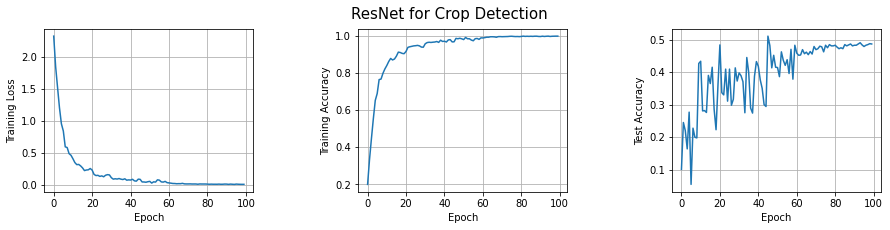

In [ ]:
print(confusion_matrix/confusion_matrix.sum(1))
plotResults(train_loss, train_acc, test_acc,titleStr="ResNet for Crop Detection")